# Here we just populate one of the eignmodes of the original LL matrix, since when you're doing just one it doesn't matter, and you can't diagonalize e12 and e23 matrices simultaneously

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def eq_mass_eigen(seed, P12, P3, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':P3}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['M']
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    # initialize in first eigenmode
    A = [1,0,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    
    zstar = secsim['S'] @ v0
    zstar = zstar/(zstar[1]-zstar[0]) # normalize so em12 = 1
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':P3,'e':abs(zstar[2])*e, 'pomega':np.arccos(np.sign(zstar[2])), 'M':np.random.random()*2*np.pi}, sim=sim)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_eigen(params): # collision: megno = 10000, lyap = 1/10, megno nan: megno = 1000, lyap = 1/20
    seed, P12, P3, etilde, mu, tmax = params
    sim = eq_mass_eigen(seed, P12, P3, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = Tsec[1] # take the middle eigenvalue corresponding to the ecom DOF
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

In [3]:
def get_pool_params(xlist, ylist, P3, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, P3, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def LLeminus(sim, times, i1, i2):
    secres = sec(sim, i1, i2)
    Gx, Gy = LLsoln(secres['M'], secres['Gammax'], secres['Gammay'], times)
    Fx = secres['R'] @ Gx/secres['Lr']**(1/2)
    Fy = secres['R'] @ Gy/secres['Lr']**(1/2)
    eminus = np.sqrt(Fx[i1-1]**2 + Fy[i1-1]**2) # eminus is always in the i1 slot
    return eminus

In [4]:
mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = 2e4

Pmin = 2/3
Pmax = 3/4
NPs = 480
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [26]:
960*320/96/48*180/3600

3.3333333333333335

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa3a9e3f28>)

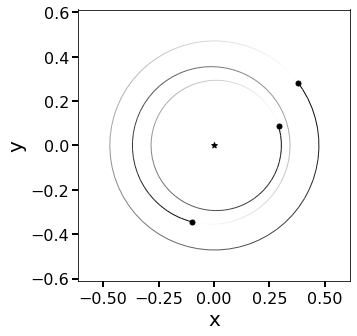

In [109]:
P12 = 1/1.33
sim = eq_mass_eigen(0, P12, P3, 0.4, mu)
rebound.OrbitPlot(sim)

In [110]:
P12 = 1/1.33
sim = eq_mass_eigen(0, P12, P3, 0.4, mu)
P12 = 1/1.33
sim = eq_mass_eigen(0, P12, P3, 0.4, mu)
P23 = 1/P12/P3
ps = sim.particles
e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
e12 = np.sqrt(e12x**2 + e12y**2)
e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
e23 = np.sqrt(e23x**2 + e23y**2)
e23/e12

0.5578703453394296

In [104]:
etilde23 = e23/(1-P23**(2/3))
etilde12 = e12/(1-P12**(2/3))
etilde23/etilde12

1.4250827462011282

In [83]:
(1-P12**(2/3))/(1-P23**(2/3))

1.2913245103814632

In [61]:
P23 = 1/P12/P3
e23overe12 = 0.5 # this is approximately constant across grid, both in P2 and e
e12covere23c = (1-P12**(2/3))/(1-P23**(2/3))
etilde23 = e12*e23overe12*e12covere23c
etilde23

0.00613850145519571

In [62]:
e23

0.004840730431268608

In [75]:
ps = sim.particles
ps[1].e, ps[2].e, ps[3].e

(0.01800822121962651, 0.02296827085508333, 0.005828487797907119)

In [76]:
secsim = sec(sim, 1, 2)
Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
vals,T = np.linalg.eigh(Mprime)
Fx0 = secsim['R'] @ secsim['Gammax']/secsim['Lr']**(1/2)
# Fy0 = 0
A = T.T @ Fx0
v0 = T @ A
v0 /= np.linalg.norm(v0)
zstar = secsim['S'] @ v0
zstar = zstar/(zstar[1]-zstar[0]) # normalize so em12 = 1 
A, zstar

(array([-4.25354986e-02,  2.55311936e-08,  6.77393954e-07]),
 array([-0.85697928,  0.14302072,  0.16666405]))

In [77]:
times = np.linspace(0, 6*secsim['Tsec'].min(), 1000)
print(times.max())

31043.990274015036


In [78]:
L = secsim['Lambda']
Gx, Gy = LLsoln(secsim['M'], secsim['Gammax'], secsim['Gammay'], times)
emx12 = Gx[1]/np.sqrt(L[1]) - Gx[0]/np.sqrt(L[0])
emy12 = Gy[1]/np.sqrt(L[1]) - Gy[0]/np.sqrt(L[0])
emx23 = Gx[2]/np.sqrt(L[2]) - Gx[1]/np.sqrt(L[1])
emy23 = Gy[2]/np.sqrt(L[2]) - Gy[1]/np.sqrt(L[1])
em12 = np.sqrt(emx12**2 + emy12**2)
em23 = np.sqrt(emx23**2 + emy23**2)
modex = v0[0]*Gx[0]/np.sqrt(L[0]) + v0[1]*Gx[1]/np.sqrt(L[1]) + v0[2]*Gx[2]/np.sqrt(L[2])
modey = v0[0]*Gy[0]/np.sqrt(L[0]) + v0[1]*Gy[1]/np.sqrt(L[1]) + v0[2]*Gy[2]/np.sqrt(L[2])

[-1.31438499e-04 -7.88936741e-11 -2.09320796e-09]
[-6.18729033e-21 -3.28421505e-21  7.10800634e-21]


In [79]:
ps = sim.particles
Nem12, Nem23, Nmodex, Nmodey = np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000)
for i, time in enumerate(times):
    sim.integrate(time)
    Nemx12 = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    Nemy12 = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    Nemx23 = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    Nemy23 = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    Nem12[i] = np.sqrt(Nemx12**2 + Nemy12**2)
    Nem23[i] = np.sqrt(Nemx23**2 + Nemy23**2)
    Nmodex[i] = zstar[0]*ps[1].e*np.cos(ps[1].pomega) + zstar[1]*ps[2].e*np.cos(ps[2].pomega) + zstar[2]*ps[3].e*np.cos(ps[3].pomega)
    Nmodey[i] = zstar[0]*ps[1].e*np.sin(ps[1].pomega) + zstar[1]*ps[2].e*np.sin(ps[2].pomega) + zstar[2]*ps[3].e*np.sin(ps[3].pomega)

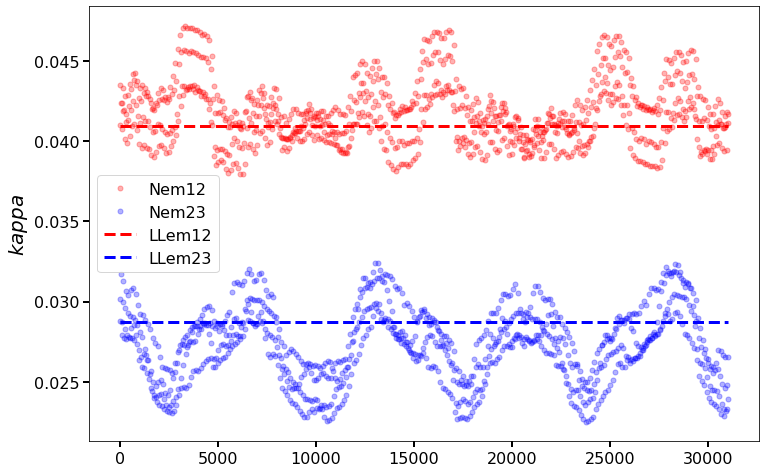

In [81]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  
#ax.plot(times,em12+em23,color='b',ls='--', label='LLsum')  


ax.set_ylabel('$kappa$')
ax.legend()
#ax.set_ylim([0,4*e])

In [40]:
ps = sim.particles
ps[1].pomega, ps[2].pomega

(-3.111988660735775, -2.5143178833549595)

In [41]:
ps[1].P, ps[2].P, ps[3].P

(0.997865865397297, 1.3970381221856, 2.0327707933787083)

In [42]:
ps[1].e, ps[2].e, ps[3].e

(0.02228774142956584, 0.002107025343602343, 0.00046140491276869456)

In [31]:
params[0]

(0, 0.6666666666666666, 2.0328, 0.0, 0.0001, 20000.0)

In [7]:
mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = 2e4

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [24]:
1/P12s/P3

array([0.73789847, 0.7378023 , 0.73770615, 0.73761004, 0.73751394,
       0.73741787, 0.73732183, 0.73722581, 0.73712982, 0.73703385,
       0.73693791, 0.73684199, 0.7367461 , 0.73665023, 0.73655439,
       0.73645857, 0.73636278, 0.73626701, 0.73617126, 0.73607555,
       0.73597985, 0.73588418, 0.73578854, 0.73569292, 0.73559733,
       0.73550176, 0.73540621, 0.73531069, 0.7352152 , 0.73511973,
       0.73502428, 0.73492886, 0.73483347, 0.7347381 , 0.73464275,
       0.73454743, 0.73445213, 0.73435686, 0.73426161, 0.73416639,
       0.73407119, 0.73397602, 0.73388087, 0.73378575, 0.73369065,
       0.73359557, 0.73350052, 0.7334055 , 0.7333105 , 0.73321552,
       0.73312057, 0.73302564, 0.73293074, 0.73283586, 0.73274101,
       0.73264618, 0.73255137, 0.7324566 , 0.73236184, 0.73226711,
       0.7321724 , 0.73207772, 0.73198307, 0.73188843, 0.73179382,
       0.73169924, 0.73160468, 0.73151015, 0.73141564, 0.73132115,
       0.73122669, 0.73113225, 0.73103784, 0.73094345, 0.73084

In [6]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('3p_eigenmode_close_2e4.npy', results)

CPU times: user 16.3 s, sys: 9.04 s, total: 25.3 s
Wall time: 2h 38min 12s


# Need to run this first to calculate the appropriate values of e23tilde, which vary over the grid

In [120]:
%%time

mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = 2e4

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

etilde23overetilde12sclose = []
for P12 in P12s:
    sim = eq_mass_eigen(0, P12, P3, 0.2, mu) # ratio of e23/e12 only changes by about 1% for different etilde
    P23 = 1/P12/P3
    ps = sim.particles
    e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    e12 = np.sqrt(e12x**2 + e12y**2)
    e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    e23 = np.sqrt(e23x**2 + e23y**2)
    e12c = (1-P12**(2/3))
    e23c = (1-P23**(2/3))
    etilde12 = e12/e12c
    etilde23 = e23/e23c
    etilde23overetilde12sclose.append(etilde23/etilde12)

CPU times: user 2min 26s, sys: 340 ms, total: 2min 27s
Wall time: 2min 27s


In [121]:
%%time

mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

etilde23overetilde12swide = []
for P12 in P12s:
    sim = eq_mass_eigen(0, P12, P3, 0.2, mu) # ratio of e23/e12 only changes by about 1% for different etilde
    P23 = 1/P12/P3
    ps = sim.particles
    e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    e12 = np.sqrt(e12x**2 + e12y**2)
    e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    e23 = np.sqrt(e23x**2 + e23y**2)
    e12c = (1-P12**(2/3))
    e23c = (1-P23**(2/3))
    etilde12 = e12/e12c
    etilde23 = e23/e23c
    etilde23overetilde12swide.append(etilde23/etilde12)

CPU times: user 2min 36s, sys: 307 ms, total: 2min 36s
Wall time: 2min 36s


In [159]:
((1-P23s**(2/3))/m23**(1/4)).shape

(960,)

In [161]:
len(etilde23overetilde12sclose)

960

In [ ]:
from matplotlib.lines import Line2D
plt.style.use('paper')

fig, axarr = plt.subplots(figsize=(12,16), nrows=2)

ax = axarr[0]

mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = 2e4

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('3p_eigenmode_close_2e4.npy')
X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
ax.set_xlabel(r"$P2/P1$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5)

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

deltas23 = (1-P23s**(2/3))/m23**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas23**(-4/3))/np.array(etilde23overetilde12sclose), color='orange', lw=5)

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12sclose, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildes12grid, tauH18, levels=[1], colors='w', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

custom_lines = [Line2D([0], [0], color='orange', lw=5), Line2D([0], [0], color='w', lw=5)]
ax.legend(custom_lines, ['2-planet criteria', '3-planet criterion'])

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

ax = axarr[1]

mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('3p_eigenmode_wide_2e4.npy')

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
ax.set_xlabel(r"$P2/P1$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5)

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

deltas23 = (1-P23s**(2/3))/m23**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas23**(-4/3))/np.array(etilde23overetilde12sclose), color='orange', lw=5)


P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12swide, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildes12grid, tauH18, levels=[1], colors='w', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

custom_lines = [Line2D([0], [0], color='orange', lw=5), Line2D([0], [0], color='w', lw=5)]
ax.legend(custom_lines, ['2-planet criteria', '3-planet criterion'])

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.3])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


In [147]:
Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('3p_eigenmode_close_2e4.npy')
X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
ax.set_xlabel(r"$P2/P1$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5, label='Hadden & Lithwick (2018)')

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12sclose, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


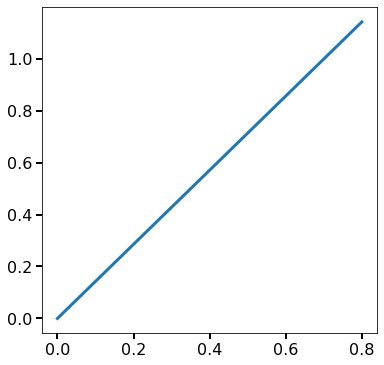

In [148]:
fig, ax = plt.subplots()
ax.plot(etildes, etildes23grid.T[0])
#ax.plot(etildes, tau12H18.T[-1])

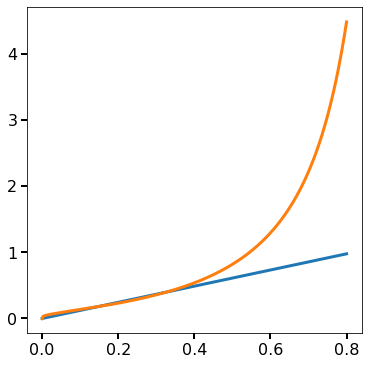

In [149]:
fig, ax = plt.subplots()
ax.plot(etildes, tau12low.T[0])
ax.plot(etildes, tau12H18.T[0])

In [150]:
mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12swide, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


(0, 2)

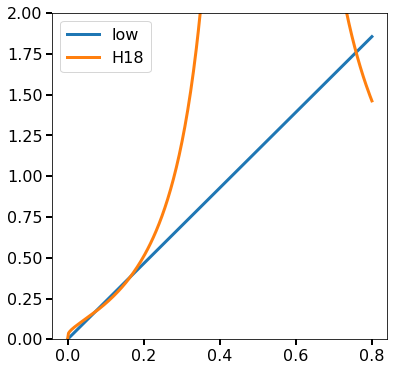

In [151]:
fig, ax = plt.subplots()
ax.plot(etildes, tau23low.T[0], label='low')
ax.plot(etildes, tau23H18.T[0], label= 'H18')
ax.legend()
ax.set_ylim([0,2])

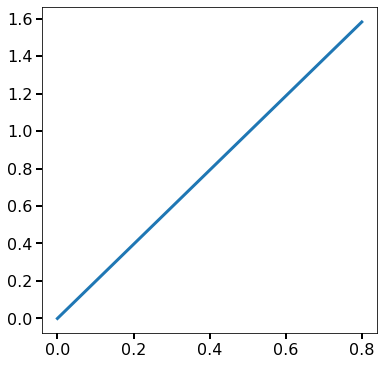

In [152]:
fig, ax = plt.subplots()
ax.plot(etildes, etildes23grid.T[0])
#ax.plot(etildes, tau12H18.T[-1])

In [ ]:
tau23low = etildes23grid * (2.9/deltas23)**2
tau12H18 = 1.15/deltas12**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23**2/np.abs(np.log(etildes23grid**0.5))**(3/2)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


Text(0.5, 0, '$P2/P1$')

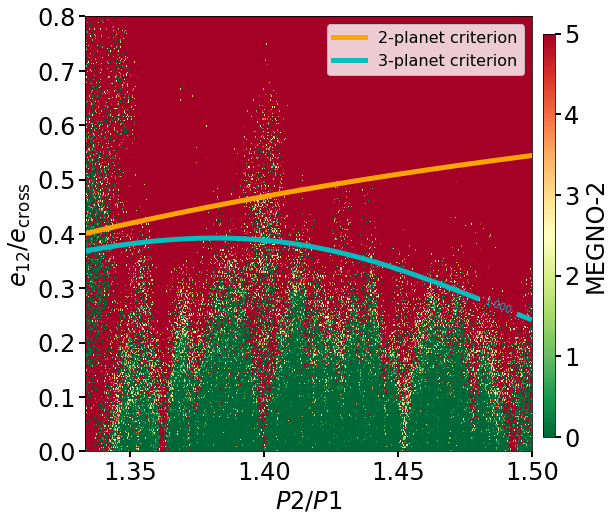

In [114]:
from matplotlib.lines import Line2D
plt.style.use('paper')


fig, ax = plt.subplots(figsize=(8,8))

megno = np.load('3p_eigenmode_close_2e4.npy')
X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
#cb = plt.colorbar(im, ax=ax)
#cb.set_label("MEGNO-2")
ax.set_xlabel(r"$P2/P1$")
#ax.set_ylabel(r"$e/e_c$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5, label='Hadden & Lithwick (2018)')

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12s, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12 = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23 = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildesgrid * (2.9/deltas12)**2
tau23low = etildes23grid * (2.9/deltas23)**2
tau12H18 = 1.15/deltas12**2/np.abs(np.log(etildesgrid**0.5))**(3/2)
tau23H18 = 1.15/deltas23**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildesgrid, taulow, levels=[1], colors='c', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

custom_lines = [Line2D([0], [0], color='orange', lw=5), Line2D([0], [0], color='c', lw=5)]
ax.legend(custom_lines, ['2-planet criterion', '3-planet criterion'])



'''
kmax=10
jmax=100
h = np.ones(11)
h[1] = 0.535
h[2] = 0.426
h[3] = 0.420
h[4] = 0.454
h[5] = 0.519
h[6] = 0.613
h[7] = 0.742
h[8] = 0.914
h[9] = 1.143
h[10] = 1.445

for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, etildemax, 100)
            dPs = j/(j-k)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*es**(k/2)
            ax.plot(P21+dPs, es, 'k', alpha=0.5)
            ax.plot(P21-dPs, es, 'k', alpha=0.5)

for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P23 = (j-k)/j # P2/P3
        alpha = P23**(2/3)
        P2 = P23*P3
        ec23 = 1-alpha
        ec21 = 1-P2**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        #print(j, k, P2)
        if P23*P3 > 1/P12s.max()-0.01 and P23*P3 < 1/P12s.min()+0.01:
            #ax.text(P23*P3-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), color='w', fontsize=20)
            e12s = np.linspace(0, 0.5, 100)
            e23s = e12s*ec21/ec23
            dPs = (j-k)/j*P3*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*e23s**(k/2)
            ax.plot(P2+dPs, es, 'b', alpha=0.5)
            ax.plot(P2-dPs, es, 'b', alpha=0.5)
'''
ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

182


Text(0.5, 0, '$P2/P1$')

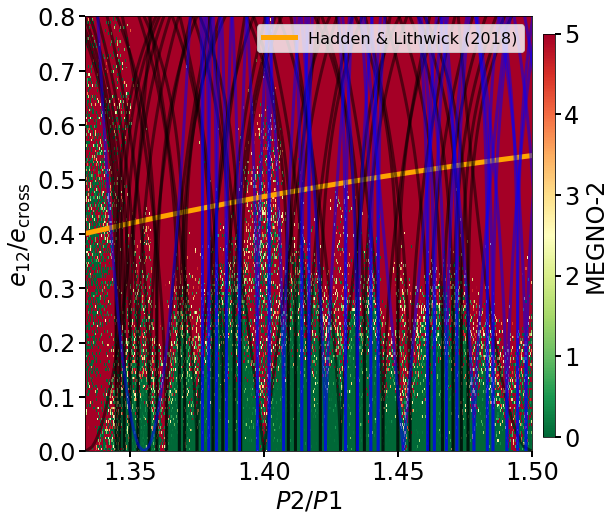

In [39]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(8,8))

megno = np.load('3p_eigenmode_close_2e4.npy')

print((res < 2.1).sum())
X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
#cb = plt.colorbar(im, ax=ax)
#cb.set_label("MEGNO-2")
ax.set_xlabel(r"$P2/P1$")
#ax.set_ylabel(r"$e/e_c$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5, label='Hadden & Lithwick (2018)')
ax.legend(loc='upper right')


kmax=10
jmax=100
h = np.ones(11)
h[1] = 0.535
h[2] = 0.426
h[3] = 0.420
h[4] = 0.454
h[5] = 0.519
h[6] = 0.613
h[7] = 0.742
h[8] = 0.914
h[9] = 1.143
h[10] = 1.445

for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, etildemax, 100)
            dPs = j/(j-k)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*es**(k/2)
            ax.plot(P21+dPs, es, 'k', alpha=0.5)
            ax.plot(P21-dPs, es, 'k', alpha=0.5)

for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P23 = (j-k)/j # P2/P3
        alpha = P23**(2/3)
        P2 = P23*P3
        ec23 = 1-alpha
        ec21 = 1-P2**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        #print(j, k, P2)
        if P23*P3 > 1/P12s.max()-0.01 and P23*P3 < 1/P12s.min()+0.01:
            #ax.text(P23*P3-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), color='w', fontsize=20)
            e12s = np.linspace(0, 0.5, 100)
            e23s = e12s*ec21/ec23
            dPs = (j-k)/j*P3*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*e23s**(k/2)
            ax.plot(P2+dPs, es, 'b', alpha=0.5)
            ax.plot(P2-dPs, es, 'b', alpha=0.5)

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

In [35]:
mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [41]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('3p_eigenmode_wide_2e4.npy', results)

CPU times: user 1min 48s, sys: 5min 33s, total: 7min 22s
Wall time: 2h 57min 53s


In [115]:
%%time

mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

etilde23overetilde12s = []
for P12 in P12s:
    sim = eq_mass_eigen(0, P12, P3, 0.2, mu) # ratio of e23/e12 only changes by about 1% for different etilde
    P23 = 1/P12/P3
    ps = sim.particles
    e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    e12 = np.sqrt(e12x**2 + e12y**2)
    e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    e23 = np.sqrt(e23x**2 + e23y**2)
    e12c = (1-P12**(2/3))
    e23c = (1-P23**(2/3))
    etilde12 = e12/e12c
    etilde23 = e23/e23c
    etilde23overetilde12s.append(etilde23/etilde12)

CPU times: user 1min 22s, sys: 211 ms, total: 1min 23s
Wall time: 1min 23s


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


Text(0.5, 0, '$P2/P1$')

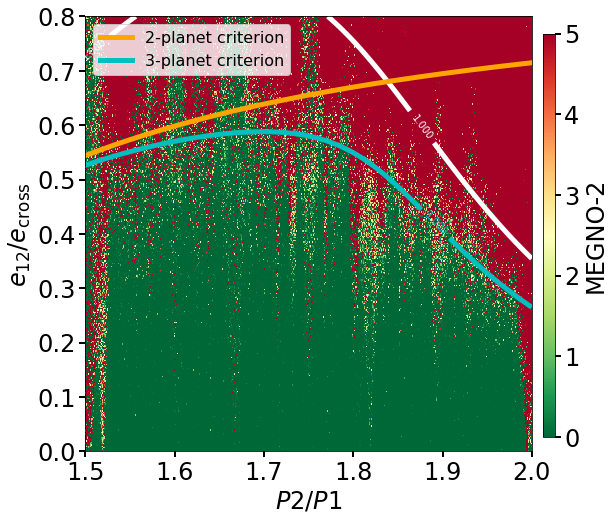

In [119]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(8,8))

megno = np.load('3p_eigenmode_wide_2e4.npy')

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=5, cmap="RdYlGn_r")
#cb = plt.colorbar(im, ax=ax)
#cb.set_label("MEGNO-2")
ax.set_xlabel(r"$P2/P1$")
#ax.set_ylabel(r"$e/e_c$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5, label='Hadden & Lithwick (2018)')

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12s, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12 = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23 = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12)**2
tau23low = etildes23grid * (2.9/deltas23)**2
tau12H18 = 1.15/deltas12**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildes12grid, tauH18, levels=[1], colors='c', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

cs = ax.contour(1/P12sgrid, etildes12grid, taulow, levels=[1], colors='w', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

custom_lines = [Line2D([0], [0], color='orange', lw=5), Line2D([0], [0], color='c', lw=5)]
ax.legend(custom_lines, ['2-planet criterion', '3-planet criterion'])

kmax=10
jmax=100
h = np.ones(11)
h[1] = 0.535
h[2] = 0.426
h[3] = 0.420
h[4] = 0.454
h[5] = 0.519
h[6] = 0.613
h[7] = 0.742
h[8] = 0.914
h[9] = 1.143
h[10] = 1.445

'''
for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, etildemax, 100)
            dPs = j/(j-k)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*es**(k/2)
            ax.plot(P21+dPs, es, 'k', alpha=0.5)
            ax.plot(P21-dPs, es, 'k', alpha=0.5)

for k in range(1,kmax+1):
    for j in range(2*k, jmax):
        if not relativelyprime(j, k):
            continue
        P23 = (j-k)/j # P2/P3
        alpha = P23**(2/3)
        P2 = P23*P3
        ec23 = 1-alpha
        ec21 = 1-P2**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        #print(j, k, P2)
        if P23*P3 > 1/P12s.max()-0.01 and P23*P3 < 1/P12s.min()+0.01:
            #ax.text(P23*P3-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), color='w', fontsize=20)
            e12s = np.linspace(0, 0.5, 100)
            e23s = e12s*ec21/ec23
            dPs = (j-k)/j*P3*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*e23s**(k/2)
            ax.plot(P2+dPs, es, 'b', alpha=0.5)
            ax.plot(P2-dPs, es, 'b', alpha=0.5)
'''

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)